<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">



# Surface water example
   
*D.A. Brakenhoff, Artesia, 2020*

This example notebook shows some how to add surface water defined in a shapefile to a MODFLOW model using the `nlmod` package.
    
    
### Contents<a id='top'></a>

1. [Load data](#1)
2. [Build model](#2)
3. [Add surface water](#3)
    1. [Intersect surface water shape with grid](#3.1)
    2. [Aggregate parameters per model cell](#3.2)
    3. [Build stress period data](#3.3)
    4. [Create RIV package](#3.4)
4. [Write + run model](#4)
5. [Visualize results](#5)

### TODO:

- Transient boundary conditions (i.e. functionality to use strings for parameters and write timeseries)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import flopy
import logging

import nlmod

In [2]:
print(f'nlmod version: {nlmod.__version__}')

# toon informatie bij het aanroepen van functies
logging.basicConfig(level=logging.INFO)

nlmod version: 0.2.5b


## [1. Load data](#top)<a id='1'></a>
Load shapefile with surface water features. 

First we define the extent of our model and subsequently input that information into the convenient methods in `nlmod` to download all the relevant data and create a Modflow6 model.

In [3]:
extent = [115900, 121000, 436600, 442000]  # Schoonhoven

In [7]:
sfw = nlmod.read.bgt.get_bgt(extent)
pg = nlmod.gwf.surface_water.download_level_areas(sfw, extent=extent)
sfw = nlmod.gwf.surface_water.add_stages_from_waterboards(sfw, pg=pg)
sfw['stage'] = sfw[['winter_stage', 'summer_stage']].mean(1)
# use a water depth of 0.5 meter
sfw['botm'] = sfw['stage'] - 0.5
# set the stage of the Lek to 0.0 m NAP and the botm to -3 m NAP
mask = sfw["bronhouder"] == "L0002"
sfw.loc[mask, 'stage'] = 0.0
sfw.loc[mask, 'botm'] = -3.0

INFO:nlmod.gwf.surface_water:Downloading level_areas for De Stichtse Rijnlanden
INFO:nlmod.gwf.surface_water:Downloading level_areas for Rivierenland
INFO:nlmod.gwf.surface_water:Downloading level_areas for Schieland en de Krimpenerwaard
c:\users\oebbe\02_python\nlmod\nlmod\gwf\surface_water.py:510: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2. Specifically: the items keyword argument will be removed.
  s = STRtree(gdf_from.geometry, items=gdf_from.index)
Adding ['summer_stage', 'winter_stage'] from level areas De Stichtse Rijnlanden to gdf: 100%|█| 819/819 [00:03<00:00, 2
c:\users\oebbe\02_python\nlmod\nlmod\gwf\surface_water.py:510: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2. Specifically: the items keyword argument will be removed.
  s = STRtree(gdf_from.geometry, items=gdf_from.index)
Adding ['summer_stage', 'winter_stage'] from level areas Rivierenland to gdf: 

Take a look at the first few rows. For adding surface water features to a MODFLOW model the following attributes must be present:

- **stage**: the water level (in m NAP)
- **botm**: the bottom elevation (in m NAP)
- **c0**: the bottom resistance (in days)

The `stage` and the `botm` columns are present in our dataset. The bottom resistance `c0` is rarely known, and is usually estimated when building the model. We will add our estimate later on.

*__Note__: the NaN's in the dataset indicate that not all parameters are known for each feature. This is not necessarily a problem but this will mean some features will not be converted to model input.*

Plot the surface water features using the column `bronhouder` to color the features. 

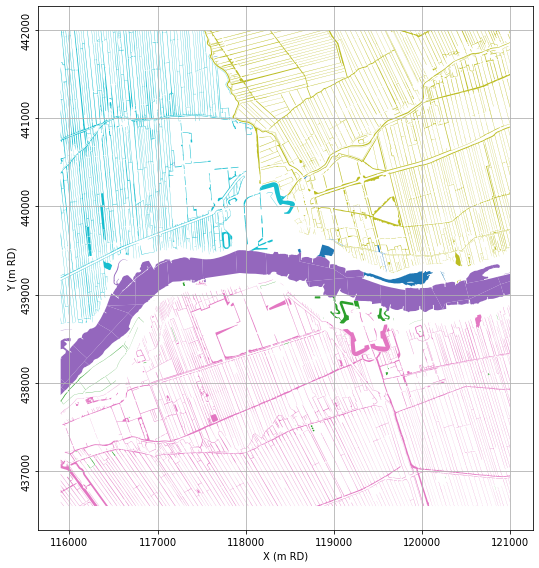

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal", adjustable="box")
sfw.plot(ax=ax, column="bronhouder")
ax.grid(True)
ax.set_xlabel("X (m RD)")
ax.set_ylabel("Y (m RD)")
plt.yticks(rotation=90, va="center")
fig.tight_layout()

Now use `stage` as the column to color the data. Note the missing features caused by the fact that the stage is undefined (NaN).

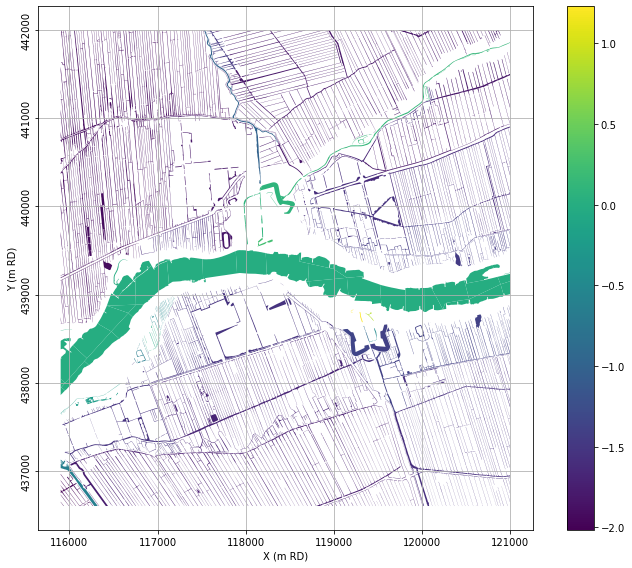

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal", adjustable="box")
sfw.plot(ax=ax, column="stage", legend=True)
ax.grid(b=True)
ax.set_xlabel("X (m RD)")
ax.set_ylabel("Y (m RD)")
plt.yticks(rotation=90, va="center")
fig.tight_layout()

## [2. Build model](#top)<a id='2'></a>

The next step is to define a model grid and build a model (i.e. create a discretization and define flow parameters).

Build the model. We're keeping the model as simple as possible.

In [10]:
use_cache = True
model_name = "model2"
model_ws = "./model2"
figdir, cachedir = nlmod.util.get_model_dirs(model_ws)

delr = delc = 50.0
start_time = "2021-01-01"

In [11]:
# layer model
layer_model = nlmod.read.regis.get_combined_layer_models(extent,
                                                         use_regis=True,
                                                         use_geotop=False,
                                                         cachedir=cachedir,
                                                         cachename='combined_layer_ds.nc')
layer_model

INFO:nlmod.cache:module of function get_combined_layer_models recently modified, not using cache
INFO:nlmod.cache:caching data -> combined_layer_ds.nc


<xarray.Dataset>
Dimensions:  (layer: 132, y: 54, x: 51)
Coordinates:
  * x        (x) float64 1.16e+05 1.16e+05 1.162e+05 ... 1.208e+05 1.21e+05
  * y        (y) float64 4.366e+05 4.368e+05 4.368e+05 ... 4.418e+05 4.42e+05
  * layer    (layer) <U64 'mv' 'HLc' 'BXz1' 'BXSCk1' ... 'MTq' 'GUq' 'VAc' 'AKc'
Data variables:
    top      (layer, y, x) float32 ...
    botm     (layer, y, x) float32 ...
    kh       (layer, y, x) float32 ...
    kv       (layer, y, x) float32 ...
Attributes: (12/40)
    references:                    https://www.dinoloket.nl/regis-ii-het-hydr...
    Conventions:                   CF-1.7
    creator_url:                   https://www.dinoloket.nl
    keywords_vocabulary:           NASA/GCMD Earth Science Keywords. Version 6.0
    acknowledgment:                https://www.dinoloket.nl
    project:                       REGIS v02r2
    ...                            ...
    geospatial_lon_resolution:     0.0014573401
    geospatial_vertical_min:       -1235.92
    geospatial_vertical_max:       322.75
    geospatial_vertical_units:     m-NAP
    geospatial_vertical_positive:  up
    extent:                        [115900, 121000, 436600, 442000]

In [12]:
# create a model ds by changing grid of layer_model
model_ds = nlmod.read.regis.to_model_ds(layer_model, model_name, model_ws, delr=delr, delc=delc)

# create model time dataset
model_ds = nlmod.mdims.set_model_ds_time(model_ds,
                                         start_time=start_time,
                                         steady_state=True)

model_ds

INFO:nlmod.read.regis:resample regis data to structured modelgrid
INFO:nlmod.mdims.mlayers:get first active modellayer for each cell in idomain


<xarray.Dataset>
Dimensions:             (y: 108, x: 102, layer: 35, time: 1)
Coordinates:
  * layer               (layer) <U64 'HLc' 'BXz2' 'BXz3' ... 'OOc' 'BRz1' 'BRk1'
  * x                   (x) float64 1.159e+05 1.16e+05 ... 1.209e+05 1.21e+05
  * y                   (y) float64 4.42e+05 4.419e+05 ... 4.367e+05 4.366e+05
  * time                (time) datetime64[ns] 2021-01-02
Data variables:
    top                 (y, x) float32 -1.31 -1.31 -1.29 ... -1.01 -1.06 -1.06
    botm                (layer, y, x) float32 -12.49 -12.49 ... -590.4 -590.4
    kh                  (layer, y, x) float32 1.0 1.0 1.0 1.0 ... 0.02 0.02 0.02
    kv                  (layer, y, x) float32 0.1 0.1 0.1 ... 0.002 0.002 0.002
    idomain             (layer, y, x) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    first_active_layer  (y, x) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    gridtype:                  structured
    extent:                    [115900, 121000, 436600, 442000]
    delr:                      50.0
    delc:                      50.0
    model_name:                model2
    mfversion:                 mf6
    model_dataset_created_on:  20220825_16:39:02
    exe_name:                  c:\users\oebbe\02_python\nlmod\nlmod\mdims\..\...
    model_ws:                  ./model2
    figdir:                    ./model2\figure
    cachedir:                  ./model2\cache
    nodata:                    -999

In [13]:
# create simulation 
sim = nlmod.gwf.sim_from_model_ds(model_ds)

# create time discretisation
tdis = nlmod.gwf.tdis_from_model_ds(model_ds, sim)

# create groundwater flow model
gwf = nlmod.gwf.gwf_from_model_ds(model_ds, sim)

# create ims
ims = nlmod.gwf.ims_to_sim(sim)

# Create discretization
dis = nlmod.gwf.dis_from_model_ds(model_ds, gwf)

# create node property flow
npf = nlmod.gwf.npf_from_model_ds(model_ds, gwf)

# Create the initial conditions package
ic = nlmod.gwf.ic_from_model_ds(model_ds, gwf, starting_head=1.0)

# Create the output control package
oc = nlmod.gwf.oc_from_model_ds(model_ds, gwf)

INFO:nlmod.gwf.sim:creating modflow SIM
INFO:nlmod.gwf.sim:creating modflow SIM, TDIS, GWF and IMS
INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow IMS


## [3. Add surface water](#top)<a id='3'></a>

Now that we have a discretization (a grid, and layer tops and bottoms) we can start processing our surface water shapefile to add surface water features to our model. The method to add surface water starting from a shapefile is divided into the following steps:

1. Intersect surface water shape with grid. This steps intersects every feature with the grid so we can determine the surface water features in each cell.
2. Aggregate parameters per grid cell. Each feature within a cell has its own parameters. For MODFLOW it is often desirable to have one representative set of parameters per cell. These representative parameters are calculated in this step.
3. Build stress period data. The results from the previous step are converted to stress period data (generally a list of cellids and representative parameters: `[(cellid), parameters]`) which is used by MODFLOW and flopy to define boundary conditions.
4. Create the Modflow6 package

The steps are illustrated below.

### [Intersect surface water shape with grid](#top)<a id='3.1'></a>

The first step is to intersect the surface water shapefile with the grid.

In [14]:
sfw_grid = nlmod.mdims.gdf2grid(sfw, gwf)

C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\flopy\utils\gridintersect.py:138: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  self.strtree = STRtree(self._get_gridshapes())
C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\flopy\utils\gridintersect.py:234: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
Intersecting with grid:   0%|                                                                 | 0/3902 [00:00<?, ?it/s]C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\numpy\core\records.py:506: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return self.setfield(val, *res)
C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\numpy\core\re

Plot the result and the model grid and color using `cellid`. It's perhaps a bit hard to see but each feature is cut by the gridlines. 

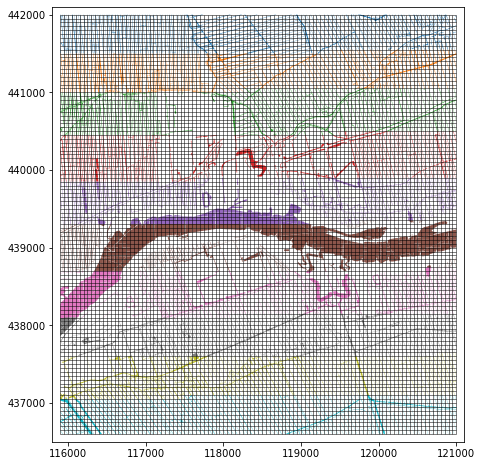

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal", adjustable="box")
sfw_grid.plot(ax=ax, column="cellid")
gwf.modelgrid.plot(ax=ax, linewidth=0.5, color="k")
xmin, xmax, ymin, ymax = extent
offset = 100
ax.set_xlim(xmin-offset, xmax+offset)
ax.set_ylim(ymin-offset, ymax+offset);
fig.savefig(os.path.join(model_ds.figdir,'surface_water_Schoonhoven.png'))

### [Aggregate parameters per model cell](#top)<a id='3.2'></a>

The next step is to aggregate the parameters for all the features in one grid cell to obtain one representative set of parameters. First, let's take a look at a grid cell containing multiple features.

In [16]:
cid = (107, 6)  # for 50 x 50 m grid
# cid = (5, 45)  # for 100 x 100 m grid
mask = sfw_grid.cellid == cid
sfw_grid.loc[mask]

,id,creationDate,LV-publicatiedatum,relatieveHoogteligging,inOnderzoek,eindRegistratie,tijdstipRegistratie,identificatie,bronhouder,bgt-status,plus-status,class,plus-type,geometrie2dWaterdeel,terminationDate,summer_stage,winter_stage,stage,botm,cellid
292,bce2dbbc5-027b-ee3d-1091-f08366bc2032,2016-06-20,2022-02-21T10:23:26,0,false,NaN,2022-02-21T10:15:34.000,G1927.35bc4b86341264fde05332a1e90aa826,W0621,bestaand,geenWaarde,waterloop,waardeOnbekend,"POLYGON ((116247.320 436647.060, 116245.190 43...",NaN,-1.00,-0.25,-0.625,-1.125,"(107, 6)"
5151,b94c6eecb-1fd4-3e15-6b32-f111b89b6955,2016-06-20,2016-09-15T15:01:42,0,false,NaN,2016-08-24T15:41:23.000,G1927.35bc4b86458a64fde05332a1e90aa826,W0621,bestaand,geenWaarde,waterloop,waardeOnbekend,"POLYGON ((116200.682 436629.617, 116200.000 43...",NaN,-1.99,-2.04,-2.015,-2.515,"(107, 6)"
5153,bf0632bc0-6726-59fd-4820-b9231c48f50f,2016-06-20,2016-09-15T15:01:42,0,false,NaN,2016-08-24T15:41:23.000,G1927.35bc4b8645d064fde05332a1e90aa826,W0621,bestaand,geenWaarde,waterloop,waardeOnbekend,"POLYGON ((116202.937 436620.942, 116200.000 43...",NaN,-1.99,-2.04,-2.015,-2.515,"(107, 6)"
5312,b6570c5e6-3607-c7f1-6ad0-5f9c7e54f197,2016-06-20,2022-01-07T17:04:40,0,false,NaN,2022-01-07T16:27:29.000,G1927.35bc4b863c1b64fde05332a1e90aa826,W0621,bestaand,geenWaarde,waterloop,waardeOnbekend,"POLYGON ((116245.933 436623.837, 116236.879 43...",NaN,-1.99,-2.04,-2.015,-2.515,"(107, 6)"
5313,b5306e6d2-3e05-bb6d-f3b8-52db6e390aa5,2016-06-20,2022-01-07T17:04:40,0,false,NaN,2022-01-07T16:27:29.000,G1927.35bc4b863fa464fde05332a1e90aa826,W0621,bestaand,geenWaarde,waterloop,waardeOnbekend,"POLYGON ((116227.311 436641.249, 116225.625 43...",NaN,-1.99,-2.04,-2.015,-2.515,"(107, 6)"


We can also plot the features within that grid cell.

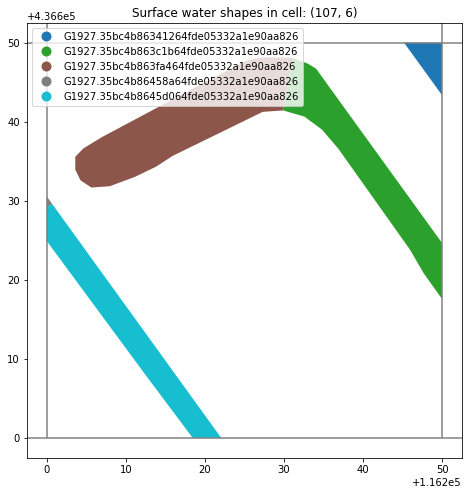

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sfw_grid.loc[mask].plot(column="identificatie", legend=True, ax=ax,
                        legend_kwds={"loc": "upper left"})
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gwf.modelgrid.plot(ax=ax)
ax.set_xlim(xlim[0], xlim[0]+model_ds.delr*1.1)
ax.set_ylim(ylim)
ax.set_title(f"Surface water shapes in cell: {cid}");
fig.savefig(os.path.join(model_ds.figdir,'surface_water_detail.png'))

Now we want to aggregate the features in each cell to obtain a representative set of parameters (`stage`, `conductance`, `bottom elevation`) to use in the model. There are several aggregation methods. Note that the names of the methods are not representative of the aggregation applied to each parameter. For a full description see the following list:

- `'area_weighted'`
  - **stage**: area-weighted average of stage in cell
  - **cond**: conductance is equal to area of surface water divided by bottom resistance
  - **elev**: the lowest bottom elevation is representative for the cell
- `'max_area'`
  - **stage**: stage is determined by the largest surface water feature in a cell
  - **cond**: conductance is equal to area of all surface water features divided by bottom resistance
  - **elev**: the lowest bottom elevation is representative for the cell
- `'de_lange'`
  - **stage**: area-weighted average of stage in cell
  - **cond**: conductance is calculated using the formulas derived by De Lange (1999).
  - **elev**: the lowest bottom elevation is representative for the cell
  
Let's try using `area_weighted`. This means the stage is the area-weighted average of all the surface water features in a cell. The conductance is calculated by dividing the total area of surface water in a cell by the bottom resistance (`c0`). The representative bottom elevation is the lowest elevation present in the cell.

In [18]:
try:
    nlmod.gwf.surface_water.aggregate_surface_water(
        sfw_grid, "area_weighted")
except ValueError as e:
    print(e)

Missing columns in DataFrame: {'c0'}


The function checks whether the requisite columns are defined in the DataFrame. We need to add a column containing the bottom resistance `c0`. Often a value of 1 day is used as an initial estimate.

In [19]:
sfw_grid["c0"] = 1.0  # days

Now aggregate the features.

In [20]:
celldata = nlmod.gwf.surface_water.aggregate_surface_water(sfw_grid, "area_weighted")

Aggregate surface water data: 100%|███████████████████████████████████████████████| 9775/9775 [00:39<00:00, 247.43it/s]


Let's take a look at the result. We now have a DataFrame with cell-id as the index and the three parameters we need for each cell `stage`, `cond` and `rbot`. The area is also given, but is not needed for the groundwater model. 

In [21]:
celldata.head(10)

stage        cond   rbot        area
0 0 -1.925  574.207336 -2.425  574.207336
  1 -1.925  313.860486 -2.425  313.860486
  2 -1.925  119.934212 -2.425  119.934212
  3 -1.925  523.168252 -2.425  523.168252
  4 -1.925  267.499086 -2.425  267.499086
  5 -1.925  184.101176 -2.425  184.101176
  6 -1.925  195.781352 -2.425  195.781352
  7 -1.925  289.174129 -2.425  289.174129
  8 -1.925  266.050263 -2.425  266.050263
  9 -1.925  396.204049 -2.425  396.204049

### [Build stress period data](#top)<a id='3.3'></a>

The next step is to take our cell-data and build convert it to 'stress period data' for MODFLOW. This is a data format that defines the parameters in each cell in the following format:

```
[[(cellid1), param1a, param1b, param1c],
 [(cellid2), param2a, param2b, param2c],
 ...]
```

The required parameters are defined by the MODFLOW-package used:

- **RIV**: for the river package `(stage, cond, rbot)`
- **DRN**: for the drain package `(stage, cond)`
- **GHB**: for the general-head-boundary package `(stage, cond)`

We're selecting the RIV package. We don't have a bottom (rbot) for each reach in celldata. Therefore we remove the reaches where rbot is nan (not a number).

In [22]:
new_celldata = celldata.loc[~celldata.rbot.isna()]
print(f'removed {len(celldata)-len(new_celldata)} reaches because rbot is nan')

removed 299 reaches because rbot is nan


In [23]:
riv_spd = nlmod.gwf.surface_water.build_spd(new_celldata, "RIV", model_ds)

Building stress period data RIV: 100%|███████████████████████████████████████████| 9476/9476 [00:01<00:00, 5444.31it/s]


Take a look at the stress period data for the river package:

In [24]:
riv_spd[:10]

[[(0, 0, 0), -1.9249999999999998, 574.2073355281742, -2.425],
 [(0, 0, 1), -1.9249999999999996, 313.86048571833, -2.425],
 [(0, 0, 2), -1.9249999999999998, 119.93421157955876, -2.425],
 [(0, 0, 3), -1.9249999999999996, 523.1682520157248, -2.425],
 [(0, 0, 4), -1.9249999999999994, 267.4990863337548, -2.425],
 [(0, 0, 5), -1.9249999999999998, 184.10117604224465, -2.425],
 [(0, 0, 6), -1.9249999999999998, 195.7813520250043, -2.425],
 [(0, 0, 7), -1.9249999999999998, 289.1741290298366, -2.425],
 [(0, 0, 8), -1.9249999999999996, 266.05026258030773, -2.425],
 [(0, 0, 9), -1.9249999999999998, 396.2040490208236, -2.425]]

### [Create RIV package](#top)<a id='3.4'></a>

The final step is to create the river package using flopy.

In [25]:
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

Plot the river boundary condition to see where rivers were added in the model

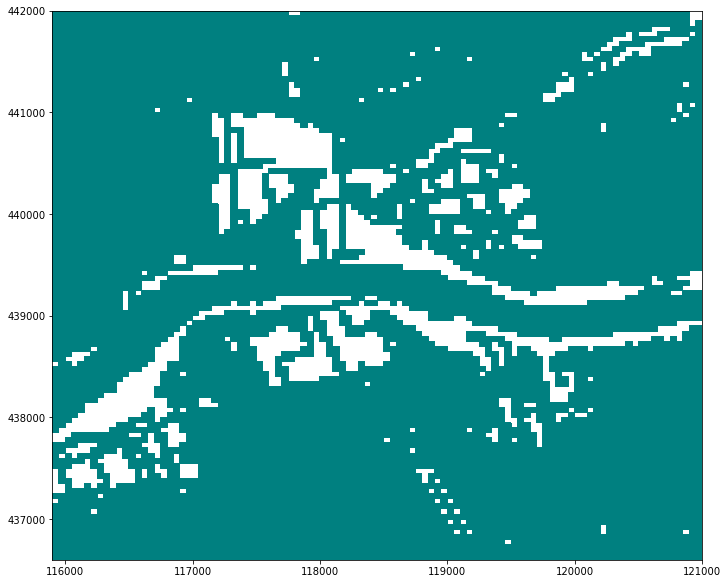

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)
mv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
mv.plot_bc("RIV");

## [4. Write + run model](#top)<a id='4'></a>

Now write the model simulation to disk, and run the simulation.

In [27]:
nlmod.gwf.write_and_run_model(gwf, model_ds, write_model_ds=True, nb_path='02_surface_water.ipynb')

INFO:nlmod.gwf.gwf:write script 2022082502_surface_water.ipynb to model workspace
INFO:nlmod.gwf.gwf:write model dataset to cache
INFO:nlmod.gwf.gwf:write modflow files to model workspace


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model model2...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 9476 based on size of stress_period_data


INFO:nlmod.gwf.gwf:run model


FloPy is using the following  executable to run the model: c:\users\oebbe\02_python\nlmod\nlmod\gwf\..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 16:14:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither 

## [5. Visualize results](#top)<a id='5'></a>

To see whether our surface water was correctly added to the model, let's visualize the results. We'll load the calculated heads, and plot them.

In [28]:
hds_obj = flopy.utils.HeadFile(os.path.join(
    model_ds.model_ws, model_ds.model_name) + ".hds")

Load the data, and set NODATA (often values of +1e30) to `np.nan`.

In [29]:
h = hds_obj.get_alldata()
h[h > 1e20] = np.nan  # set NODATA to NaN

Plot the heads in a specific model layer

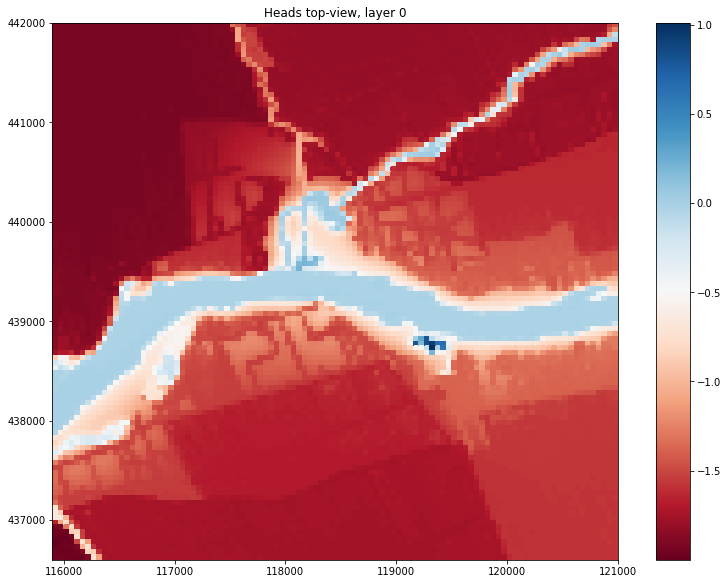

In [30]:
ilay = 0
fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)
mv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=ilay)
qm = mv.plot_array(h[-1], cmap="RdBu")  # last timestep
mv.plot_ibound()  # plot inactive cells in red
fig.colorbar(qm, shrink=1.0)
ax.set_title(f"Heads top-view, layer {ilay}");
fig.savefig(os.path.join(model_ds.figdir,f'heads_layer{ilay}.png'))

In cross-section

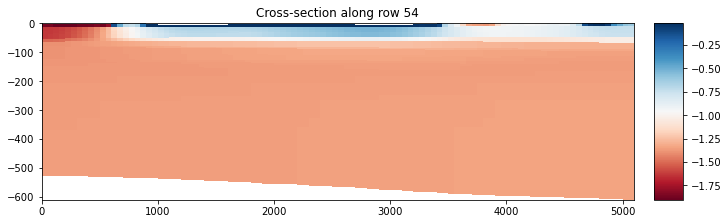

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True)
xs = flopy.plot.PlotCrossSection(
    model=gwf, ax=ax, line={"row": gwf.modelgrid.nrow // 2})
qm = xs.plot_array(h[-1], cmap="RdBu")  # last timestep
xs.plot_ibound()  # plot inactive cells in red
fig.colorbar(qm, shrink=1.0)
row = gwf.modelgrid.nrow // 2
ax.set_title(f"Cross-section along row {row}");
fig.savefig(os.path.join(model_ds.figdir,f'heads_cross_section_along_row{row}.png'))